<a href="https://colab.research.google.com/github/jinzus/miscellaneous/blob/main/FUZZY_CLUSTERING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fuzzy clustering is a technique that allows an instance to belong to more than one cluster simultaneously. This concept is sometimes called "soft clustering".
Let's implement the algorithm from scratch!

In [ ]:
# Import dependencies

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
%matplotlib inline

Text(0.5, 1.0, 'Scatter plot')

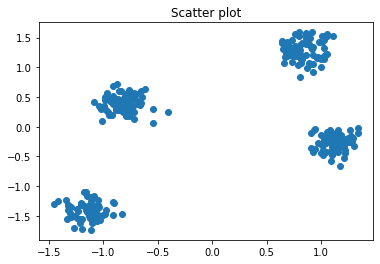

In [ ]:
# Create the dataset

def generate_dataset(n_instances):
  dataset=np.empty((n_instances,2))
  n_instances_gauss_1=75
  n_instances_gauss_2=75
  n_instances_gauss_3=75
  n_instances_gauss_4=75
  gauss_1_loc_1,gauss_1_scale_1=-15,3.5
  gauss_1_loc_2,gauss_1_scale_2=-14,3.5
  gauss_2_loc_1,gauss_2_scale_1=-4,3.5
  gauss_2_loc_2,gauss_2_scale_2=32,3.5
  gauss_3_loc_1,gauss_3_scale_1=60,3.5
  gauss_3_loc_2,gauss_3_scale_2=16,3.5
  gauss_4_loc_1,gauss_4_scale_1=50,3.5
  gauss_4_loc_2,gauss_4_scale_2=54,3.5

  for item in range(n_instances_gauss_1):
    feat_1=np.random.normal(gauss_1_loc_1,gauss_1_scale_1,1)+np.random.randint(0,2,1)
    feat_2=np.random.normal(gauss_1_loc_2,gauss_1_scale_2,1)+np.random.randint(0,2,1)
    dataset[item,0]=feat_1
    dataset[item,1]=feat_2

  for item in range(n_instances_gauss_1,n_instances_gauss_1+n_instances_gauss_2):
    feat_1=np.random.normal(gauss_2_loc_1,gauss_2_scale_1,1)+np.random.randint(0,2,1)
    feat_2=np.random.normal(gauss_2_loc_2,gauss_2_scale_2,1)+np.random.randint(0,2,1)
    dataset[item,0]=feat_1
    dataset[item,1]=feat_2

  for item in range(n_instances_gauss_1+n_instances_gauss_2,n_instances_gauss_1+n_instances_gauss_2+n_instances_gauss_3):
    feat_1=np.random.normal(gauss_3_loc_1,gauss_3_scale_1,1)+np.random.randint(0,2,1)
    feat_2=np.random.normal(gauss_3_loc_2,gauss_3_scale_2,1)+np.random.randint(0,2,1)
    dataset[item,0]=feat_1
    dataset[item,1]=feat_2
  
  for item in range(n_instances_gauss_1+n_instances_gauss_2+n_instances_gauss_3,n_instances_gauss_1+n_instances_gauss_2+n_instances_gauss_3+n_instances_gauss_4):
    feat_1=np.random.normal(gauss_4_loc_1,gauss_4_scale_1,1)+np.random.randint(0,2,1)
    feat_2=np.random.normal(gauss_4_loc_2,gauss_4_scale_2,1)+np.random.randint(0,2,1)
    dataset[item,0]=feat_1
    dataset[item,1]=feat_2
  
  return StandardScaler().fit_transform(dataset)

np.random.seed(18)
dataset=generate_dataset(300)
plt.scatter(dataset[:,0],dataset[:,1])
plt.title("Scatter plot",fontsize=12)

Quality of the reduction:  [0.76056381]


Text(0, 0.5, 'Compressed feature')

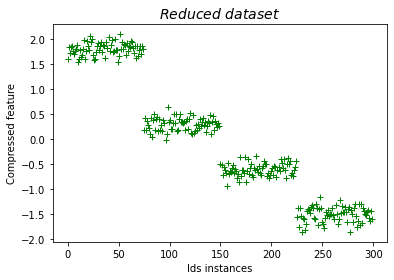

In [ ]:
# For visualization purposes we'll project down to 1D using PCA

pca=PCA(n_components=1)
dataset_1d=pca.fit_transform(dataset)
print("Quality of the reduction: ",pca.explained_variance_ratio_)
plt.plot(dataset_1d,"g+")
plt.title("$Reduced$ $dataset$",fontsize=14)
plt.xlabel("Ids instances")
plt.ylabel("Compressed feature")

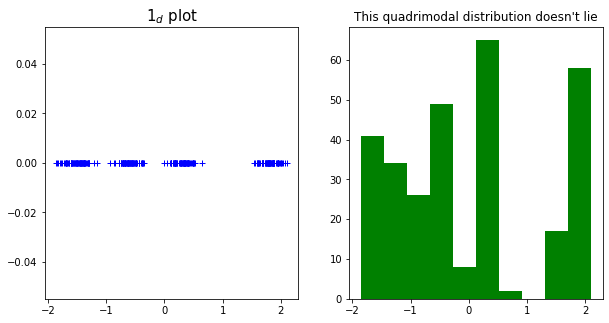

In [ ]:
# But in this case a 1D plot could help 

def mono_d_plot(data,members=None,cl=None,print_cl=False):
  if print_cl:
    assignments=np.argmax(members,axis=-1)
    val=0.
    red=data[:,-1]
    for ind,(to_cl,to_inst) in enumerate(zip(("bx","rx","kx","cx"),("bo","ro","ko","co"))):
      plt.plot(cl[ind],np.zeros_like(cl[ind])+val,to_cl,markersize=16,label="Center {:d}".format(ind))
      plt.plot(red[assignments==ind],np.zeros_like(red[assignments==ind])+val,to_inst,label="Instances to clust {:d}".format(ind),markersize=2)
    plt.title("$Hard$ $Cluster$ $assignments$",fontsize=15)
    plt.legend(loc="upper left")
  else:
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    val=0.
    red=data[:,-1]
    plt.plot(red,np.zeros_like(red)+val,"b+")
    plt.title("$1_d$ plot",fontsize=15)
    plt.subplot(122)
    plt.hist(dataset_1d,color="g")
    plt.title("This quadrimodal distribution doesn't lie",fontsize=12)

mono_d_plot(dataset_1d)

In [ ]:
def random_init(data,n_clusters=4):
  U=np.random.rand(len(data),4)
  U_mat=np.empty((U.shape[0],U.shape[1]))
  for item in range(len(data)):
    U_mat[item]=U[item]/np.sum(U[item])
  return U_mat

def update(data,u_mat,m=2):
  # Update centers
  c_j=(np.power(u_mat,m)*data).sum(axis=0)/np.power(u_mat,m).sum(axis=0)
  # Update the degree of membership
  D=np.empty(u_mat.shape)
  for i in range(D.shape[0]):
    for j in range(D.shape[-1]):
      D[i,j]=euclidean(data[i],c_j[j])  
  U_new=np.empty(u_mat.shape)
  for i in range(U_new.shape[0]):
    for j in range(U_new.shape[-1]):
      U_new[i,j]=1/np.sum((D[i,j]/D[i])**(2/(m-1)))
  # Compute cost
  cost=np.sum(np.power(U_new,m)*D)
  return U_new,cost,c_j

In [ ]:
store_cost=[]
max_iter=100
eps=.001
for iter in range(max_iter):
  if iter==0:
    np.random.seed(12)
    U=random_init(dataset_1d)
  U_old=U
  U,cost,clusters=update(dataset_1d,U_old)
  store_cost.append(cost)
  if np.max(abs(U-U_old))<eps:
    print("Convergence in {:d} iterations".format(iter+1))
    break

Convergence in 10 iterations


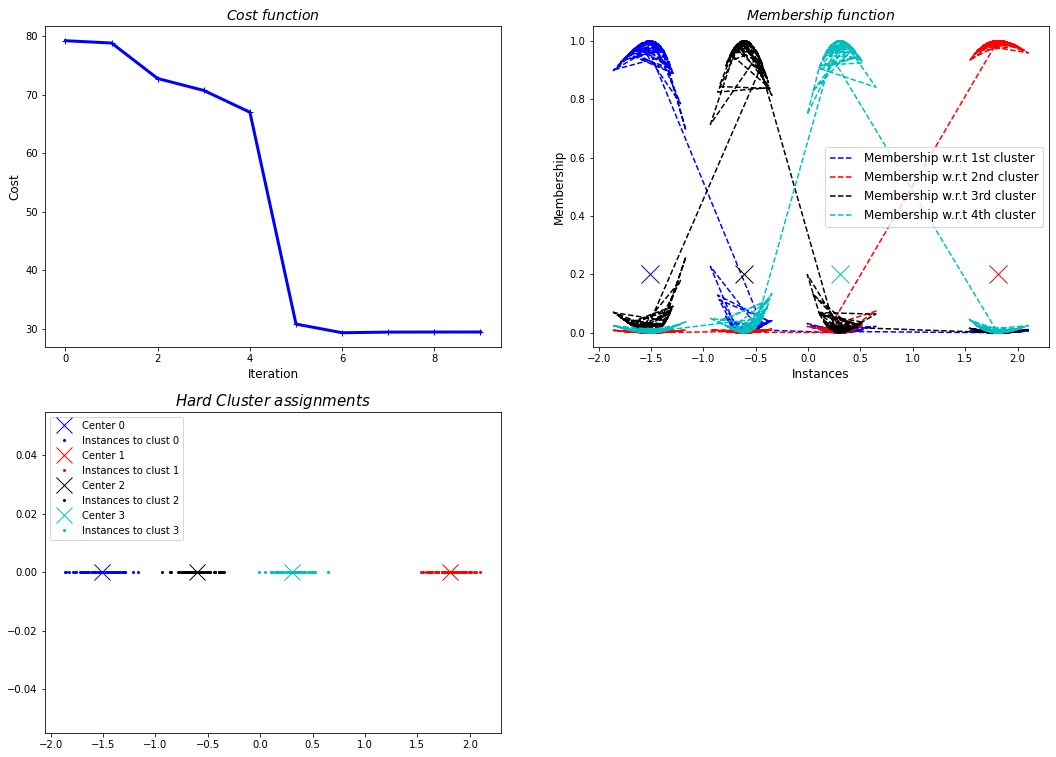

In [ ]:
# Let's plot the cost and the membership function

plt.figure(figsize=(18,13))
plt.subplot(221)
plt.plot(store_cost,"b+-",linewidth=3)
plt.title("$Cost$ $function$",fontsize=14)
plt.xlabel("Iteration",fontsize=12)
plt.ylabel("Cost",fontsize=12)
plt.subplot(222)
plt.plot(dataset_1d,U[:,0],"b--",label="Membership w.r.t 1st cluster")
plt.plot(dataset_1d,U[:,1],"r--",label="Membership w.r.t 2nd cluster")
plt.plot(dataset_1d,U[:,2],"k--",label="Membership w.r.t 3rd cluster")
plt.plot(dataset_1d,U[:,3],"c--",label="Membership w.r.t 4th cluster")
for item,aes in zip(clusters,("bx","rx","kx","cx")):
  plt.plot(item,.2,aes,markersize=18)
plt.legend(loc="best",fontsize=12)
plt.title("$Membership$ $function$",fontsize=14)
plt.xlabel("Instances",fontsize=12)
plt.ylabel("Membership",fontsize=12)
plt.subplot(223)
mono_d_plot(dataset_1d,U,clusters,True)


In [ ]:
class Fuzzy_C_Means:
  def __init__(self,data,max_iter=100,eps=.001,n_clusters=4,set_seed=13):
    self.data=data
    self.max_iter=max_iter
    self.eps=eps
    self.n_clusters=n_clusters
    self.set_seed=set_seed
  def train(self):
    def random_init(data=self.data,n_clusters=self.n_clusters):
      U=np.random.rand(len(data),n_clusters)
      U_mat=np.empty((U.shape[0],U.shape[1]))
      for item in range(len(data)):
        U_mat[item]=U[item]/np.sum(U[item])
      return U_mat
    def update(u_mat,data=self.data,m=2):
      c_j=np.empty((self.n_clusters,data.shape[-1]))
      for item in range(c_j.shape[-1]):
        c_j[:,item]=(np.power(u_mat,m)*data[:,item][:,np.newaxis]).sum(axis=0)/np.power(u_mat,m).sum(axis=0)
      D=np.empty((u_mat.shape))
      for i in range(D.shape[0]):
        for j in range(D.shape[1]):
          D[i,j]=euclidean(data[i],c_j[j])
      U_new=np.empty(u_mat.shape)
      for i in range(U_new.shape[0]):
        for j in range(U_new.shape[-1]):
          U_new[i,j]=1/np.sum((D[i,j]/D[i])**(2/(m-1)))
      cost=np.sum(np.power(U_new,m)*D)
      return U_new,cost,c_j
    store_cost=[]
    for iter in range(self.max_iter):
      if iter==0:
        np.random.seed(self.set_seed)
        U=random_init(self.data)
      U_old=U
      U,cost,clusters=update(U_old)
      store_cost.append(cost)
      if np.max(abs(U-U_old))<self.eps:
        print("Convergence in {:d} iterations".format(iter+1))
        break
    return store_cost,U,clusters


In [ ]:
fuzzy=Fuzzy_C_Means(dataset)
get_cost,get_membership,get_clusters=fuzzy.train()

Convergence in 9 iterations


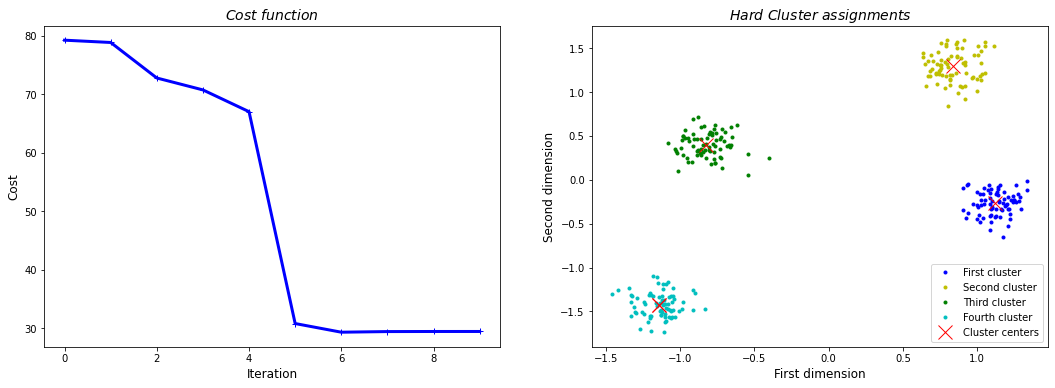

In [ ]:
def plot_2d(data,cl,membership):
  ass_index=np.argmax(membership,axis=-1)
  plt.plot(dataset[:,0][ass_index==0],dataset[:,1][ass_index==0],"b.",label="First cluster")
  plt.plot(dataset[:,0][ass_index==1],dataset[:,1][ass_index==1],"y.",label="Second cluster")
  plt.plot(dataset[:,0][ass_index==2],dataset[:,1][ass_index==2],"g.",label="Third cluster")
  plt.plot(dataset[:,0][ass_index==3],dataset[:,1][ass_index==3],"c.",label="Fourth cluster")
  for centroid in range(4):
    plt.plot(cl[centroid,0],cl[centroid,1],"rx",markersize=14)
    if centroid==3:
      plt.plot(cl[centroid,0],cl[centroid,1],"rx",markersize=14,label="Cluster centers")
  plt.legend(loc="lower right")
  plt.title("$Hard$ $Cluster$ $assignments$",fontsize=14)
  plt.xlabel("First dimension",fontsize=12)
  plt.ylabel("Second dimension",fontsize=12)
  
plt.figure(figsize=(18,13))
plt.subplot(221)
plt.plot(store_cost,"b+-",linewidth=3)
plt.title("$Cost$ $function$",fontsize=14)
plt.xlabel("Iteration",fontsize=12)
plt.ylabel("Cost",fontsize=12)
plt.subplot(222)
plot_2d(dataset,get_clusters,get_membership)


Now we try do something nice and easy using the class we have just created, image segmentation repeated with different number of clusters.

Text(0.5, 1.0, 'Original Image')

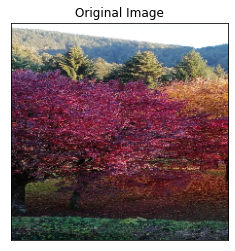

In [ ]:
import os
from imageio import imread
import tensorflow as tf

pathname="/content/drive/My Drive/Foto da Andrea"
img=imread(pathname)
imshape=224
img=tf.image.resize(img[150:img.shape[0]-100,100:img.shape[1]-200]/255.,[imshape,imshape])
plt.imshow(img)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.title("Original Image")



Convergence in 22 iterations
Convergence in 20 iterations
Convergence in 62 iterations


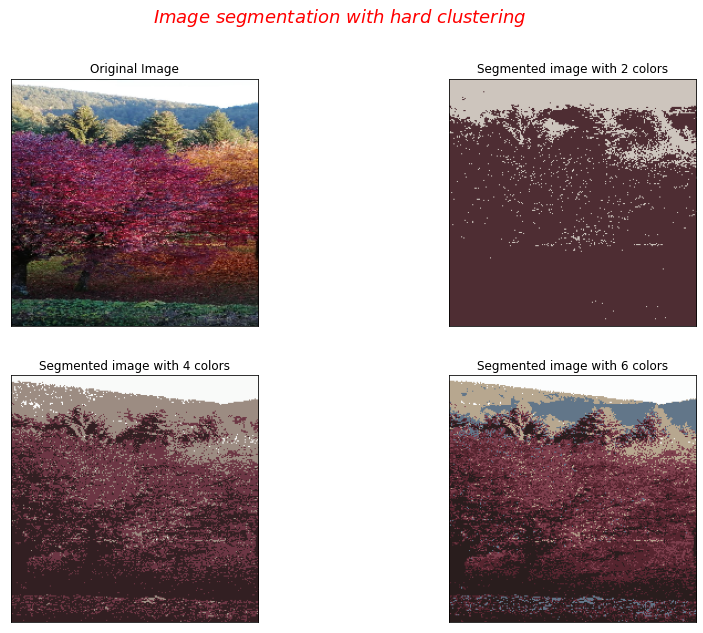

In [ ]:
plt.figure(figsize=(15,10))
plt.suptitle("$Image$ $segmentation$ $with$ $hard$ $clustering$",fontsize=18,color="r")
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.subplot(221)
plt.imshow(img)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.title("Original Image")
U_total=[]
Cl_total=[]
for idx,col in enumerate((2,4,6)):
  plt.subplot(222+idx)
  bi_d_img=np.reshape(img,(imshape**2,3))
  fuzzy=Fuzzy_C_Means(bi_d_img,n_clusters=col)
  get_cost_,get_membership_,get_clusters_=fuzzy.train()
  indexes=np.argmax(get_membership_,axis=-1)
  transform=get_clusters_[indexes]
  new_img=transform.reshape(imshape,imshape,3)
  plt.imshow(new_img)
  plt.gca().get_yaxis().set_visible(False)
  plt.gca().get_xaxis().set_visible(False)
  plt.title("Segmented image with {:d} colors".format(col))
  U_total.append(get_membership_)
  Cl_total.append(get_clusters_)

# ... however, in this case we have substituted each pixel with the center having the highest degree of membership.
# In other words, we have done hard clustering! But this doens't make much sense with Fuzzy clustering; in fact we could perform hard clustering with
# a simple k_means algorithm at a lesser computational complexity.

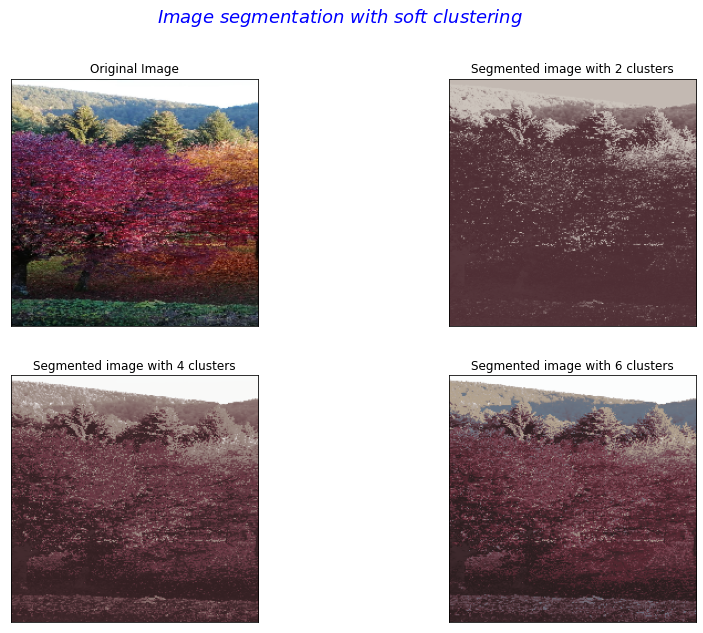

In [25]:
# Here we perform soft clustering

def soft_assignment(u,c):
  return np.dot(u,c)
  
plt.figure(figsize=(15,10))
plt.suptitle("$Image$ $segmentation$ $with$ $soft$ $clustering$",fontsize=18,color="b")
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.subplot(221)
plt.imshow(img)
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.title("Original Image")
for idx,col in enumerate((2,4,6)):
  plt.subplot(222+idx)
  bi_d_img=np.reshape(img,(imshape**2,3))
  transform=soft_assignment(U_total[idx],Cl_total[idx])
  new_img=transform.reshape(imshape,imshape,3)
  plt.imshow(new_img)
  plt.gca().get_yaxis().set_visible(False)
  plt.gca().get_xaxis().set_visible(False)
  plt.title("Segmented image with {:d} clusters".format(col))
  

